### Table of Contents
- [1. Import Data](#1)<br>
- [2. Describe Dataset](#2)<br>
- [3. Data Cleaning](#3)<br>
- [4. EDA](#4)<br>
- [5. Modelling](#5)<br>
  - [5-1. Train Test Split](#6)<br>
  - [5-2. Feature Engineering](#7)<br>
  - [5-3. Model Evaluation Functions](#8)<br>
  - [5-4. Logistic Regression](#9)<br>
  - [5-5. Logistic Regression (Optimisation)](#10)<br>
- [6. Lists of Churn Likelihood](#11)
  - [6-1. Churn risk of all our remaining customers](#12)<br>
  - [6-2. Customers we think are at risk of churning](#13)

In [504]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE

### <a id = "1"> 1. Import Data</a>

In [505]:
churn = pd.read_excel("customer_churn.xlsx")
pd.set_option('display.max_columns', None)
churn.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,Competitor had better devices


### <a id = "2"> 2. Describe Dataset</a>

In [506]:
churn.shape

(7043, 31)

In [507]:
# Check datatypes
churn.dtypes

CustomerID            object
Count                  int64
Country               object
State                 object
City                  object
Zip Code               int64
Lat Long              object
Latitude             float64
Longitude            float64
Gender                object
Senior Citizen        object
Partner               object
Dependents            object
Tenure Months          int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges         object
Churn Label           object
Churn Value            int64
Churn Reason          object
dtype: object

In [508]:
# Check nulls
churn.isnull().sum()

CustomerID              0
Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges           0
Churn Label             0
Churn Value             0
Churn Reason         5174
dtype: int64

In [509]:
# Nulls in 'Churn Reason' feature => Haven't churned yet
print(len(churn[churn['Churn Reason'].isnull()]))
print(len(churn[churn['Churn Label']=='No']))
print(len(churn[churn['Churn Value']==0]))

5174
5174
5174


### <a id = "3"> 3. Data Cleaning</a>

In [510]:
# CustomerID: Each customer has their own ID
print(f"#_of_unique_id: {len(churn.CustomerID.unique())}")
print(f"# or rows: {churn.shape[0]}")

#_of_unique_id: 7043
# or rows: 7043


In [511]:
# Count
print(f"Count: {churn.Count.unique()}")

Count: [1]


In [512]:
# Country
print(f"Country: {churn.Country.unique()}")

Country: ['United States']


In [513]:
# State
print(f"State: {churn.State.unique()}")

State: ['California']


In [514]:
# City
print(f"City: {churn.City.unique()}")
print(f"# of City: {len(churn.City.unique())}")

City: ['Los Angeles' 'Beverly Hills' 'Huntington Park' ... 'Standish' 'Tulelake'
 'Olympic Valley']
# of City: 1129


In [515]:
# Churn Reasons
print(f"Reasons: {churn['Churn Reason'].unique()}")

Reasons: ['Competitor made better offer' 'Moved' 'Competitor had better devices'
 'Competitor offered higher download speeds'
 'Competitor offered more data' 'Price too high' 'Product dissatisfaction'
 'Service dissatisfaction' 'Lack of self-service on Website'
 'Network reliability' 'Limited range of services'
 'Lack of affordable download/upload speed' 'Long distance charges'
 'Extra data charges' "Don't know" 'Poor expertise of online support'
 'Poor expertise of phone support' 'Attitude of service provider'
 'Attitude of support person' 'Deceased' nan]


In [516]:
# Exclude columns with non-informative values
features = ['Gender', 'Senior Citizen','Partner', 'Dependents', 'Tenure Months', 'Phone Service', 'Multiple Lines',
            'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
            'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method', 'Monthly Charges',
            'Total Charges', 'Churn Value', 'Churn Label']

clean_churn = churn[features].copy()
clean_churn.head()

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value,Churn Label
0,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,Yes
1,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,Yes
2,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1,Yes
3,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1,Yes
4,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1,Yes


In [517]:
# Reduced from 31 features to 20 features
clean_churn.shape

(7043, 21)

In [518]:
clean_churn.dtypes

Gender                object
Senior Citizen        object
Partner               object
Dependents            object
Tenure Months          int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges         object
Churn Value            int64
Churn Label           object
dtype: object

In [519]:
# Understand each categorical feature's values
cat_feature = ['Gender', 'Senior Citizen','Partner', 'Dependents', 'Phone Service', 'Multiple Lines', 'Internet Service',
               'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
               'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method']

for feature in cat_feature:
    print(f"{feature}: {clean_churn[feature].unique()}")

Gender: ['Male' 'Female']
Senior Citizen: ['No' 'Yes']
Partner: ['No' 'Yes']
Dependents: ['No' 'Yes']
Phone Service: ['Yes' 'No']
Multiple Lines: ['No' 'Yes' 'No phone service']
Internet Service: ['DSL' 'Fiber optic' 'No']
Online Security: ['Yes' 'No' 'No internet service']
Online Backup: ['Yes' 'No' 'No internet service']
Device Protection: ['No' 'Yes' 'No internet service']
Tech Support: ['No' 'Yes' 'No internet service']
Streaming TV: ['No' 'Yes' 'No internet service']
Streaming Movies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'Two year' 'One year']
Paperless Billing: ['Yes' 'No']
Payment Method: ['Mailed check' 'Electronic check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [520]:
# 'Total Charges': object => float
# If the customer's 'Tenure Months' is 0, the 'Total Charges' has an empty string (" ")
print(f"Total Charges with empty string: {len(clean_churn[clean_churn['Total Charges'] == ' '])}") # Drop
clean_churn.drop(clean_churn[clean_churn['Total Charges'] == " "].index, inplace = True)
clean_churn['Total Charges'] = clean_churn['Total Charges'].astype('float')

Total Charges with empty string: 11


In [521]:
clean_churn.corr()

,Tenure Months,Monthly Charges,Total Charges,Churn Value
Tenure Months,1.000000,0.246862,0.825880,-0.354049
Monthly Charges,0.246862,1.000000,0.651065,0.192858
Total Charges,0.825880,0.651065,1.000000,-0.199484
Churn Value,-0.354049,0.192858,-0.199484,1.000000


### <a id = "4"> 4. EDA</a>

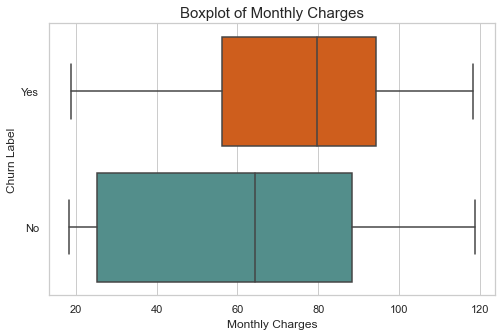

In [522]:
sns.set(style="whitegrid")
colors = ["#eb5600", "#499894"]
plt.figure(figsize=(8,5))
ax = sns.boxplot(data = churn, x = "Monthly Charges", y = "Churn Label", palette=colors)
plt.title("Boxplot of Monthly Charges", fontsize=15)
plt.xlabel("Monthly Charges", fontsize=12)
plt.ylabel("Churn Label", fontsize=12)
plt.show()

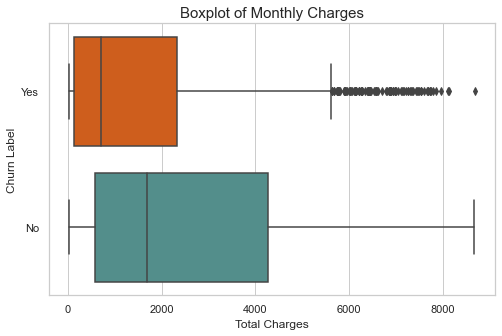

In [523]:
plt.figure(figsize=(8,5))
ax = sns.boxplot(data = clean_churn, x = "Total Charges", y = "Churn Label", palette=colors)
plt.title("Boxplot of Monthly Charges", fontsize=15)
plt.xlabel("Total Charges", fontsize=12)
plt.ylabel("Churn Label", fontsize=12)
colors = ["#eb5600", "#499894"]
plt.show()

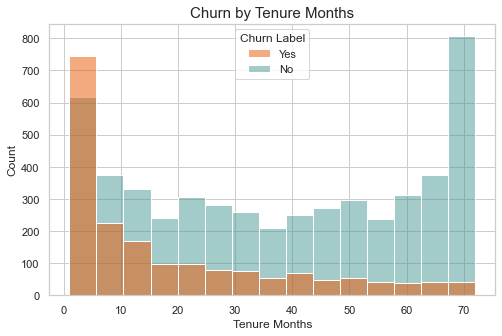

In [524]:
plt.figure(figsize=(8,5))
colors = ["#eb5600", "#499894"]
sns.histplot(data = clean_churn, x = 'Tenure Months', hue = 'Churn Label', bins = 15, palette=colors)
plt.title("Churn by Tenure Months", fontsize=15)
plt.show()

In [525]:
churn_rate_service = pd.read_csv('by_service.csv')
churn_rate_service

,Service,% Total,% Churned,% Stay
0,Phone Service,100,26.71,73.29
1,Multiple Lines,100,28.61,71.39
2,Internet Service,100,31.83,68.17
3,Online Security,100,14.61,85.39
4,Online Backup,100,21.53,78.47
5,Device Protection,100,22.50,77.50
6,Tech Support,100,15.17,84.83
7,Streaming TV,100,30.07,69.93
8,Streaming Movies,100,29.94,70.06


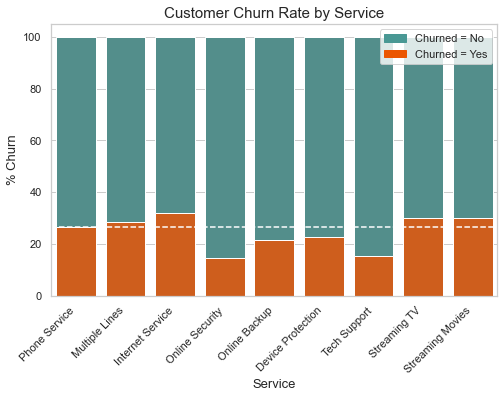

In [526]:
plt.figure(figsize = (8,5))

b1 = sns.barplot(x = 'Service', y = '% Total', data = churn_rate_service, color="#499894")
b2 = sns.barplot(x = 'Service', y = '% Churned', data = churn_rate_service, color="#eb5600")

top_bar = mpatches.Patch(color = "#499894", label = 'Churned = No')
bottom_bar = mpatches.Patch(color = "#eb5600", label = 'Churned = Yes')
plt.legend(handles = [top_bar, bottom_bar])
plt.title('Customer Churn Rate by Service', fontsize = 15)
plt.xlabel("Service", fontsize=13)
plt.ylabel("% Churn", fontsize=13)
plt.xticks(rotation = 45, ha = 'right')
plt.axhline(y=26.54, color='white', linestyle='--')

plt.show()

More visualisations were made with Tableau.

### <a id = "5"> 5. Modelling</a>

#### <a id = "6"> 5-1. Train-Test Split</a>

In [583]:
fea_cols = list(clean_churn.columns)
fea_cols.remove('Churn Value')
fea_cols.remove('Churn Label')

X = clean_churn[fea_cols]
y = clean_churn['Churn Value']

In [584]:
X_train, X_test,y_train,y_test = train_test_split(X, y, random_state=24)

#### <a id = "7"> 5-2. Feature Engineering</a>

In [529]:
def feature_eng(df, label_enc, one_hot_enc):
           
    # Label Encoding
    for feature in label_enc:
        if feature == 'Gender':
            df.loc[:,'Gender'] = df['Gender'].map({'Male':0, 'Female':1})
        else:
            df.loc[:, feature] = df[feature].map({'No':0, 'Yes':1})
    
    # One-Hot Encoding        
    for feature in one_hot_enc:
        df = pd.get_dummies(df, columns=[feature], prefix = feature)
    
    '''
    # Numeric values => log
    df.loc[:,'Tenure Months'] = np.log(df['Tenure Months'])
    df.loc[:,'Total Charges'] = np.log(df['Total Charges'])
    df.loc[:,'Monthly Charges'] = np.log(df['Monthly Charges'])
    '''
    
    return df

In [585]:
label_features = ['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Paperless Billing']
one_hot_features = ['Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection',
                    'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Payment Method']

In [586]:
X_train_eng = feature_eng(X_train, label_features, one_hot_features)
X_test_eng = feature_eng(X_test, label_features, one_hot_features)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


#### <a id = "8"> 5-3. Model Evaluation Functions</a>

In [532]:
def top_features(X_eng, clf, clf_name):
    if clf_name == 'Logistic Regression':
        weights = pd.Series(clf.coef_[0], index = X_eng.columns.values).sort_values(ascending=False)
    
    else:
        weights = pd.Series(clf.feature_importances_, index = X_eng.columns.values).sort_values(ascending=False)
    
    top_5 = weights[:5]
    
    plt.figure(figsize=(8,5))
    plt.title(f'{clf_name} - Top 5 Features')
    top_5.plot(kind = "bar")
    
    return None    

In [533]:
def produce_confusion(y_pred, y_real):    
    
    # build the CM
    cm = confusion_matrix(y_real, y_pred)
    ax = plt.subplot()
    
    sns.heatmap(cm, annot=True, ax=ax, fmt="g")
    
    # labels, title, ticks
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('Real labels')
    ax.xaxis.set_ticklabels(['Not Churn', 'Churn'])
    ax.yaxis.set_ticklabels(['Not Churn', 'Churn']);
    
    
    return None

In [534]:
def produce_roc_curve(clf, X, y_real, clf_name):
    y_score = clf.predict_proba(X)[:,1]
    
    fp, tp, thresh = roc_curve(y_real, y_score)
    
    plt.plot(fp, tp, label = f'AUC {clf_name}: {round(roc_auc_score(y_test,y_score),3)}')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.title(f'ROC {clf_name}')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.fill_between(fp, tp, 0, facecolor='azure', alpha=1)
    plt.legend(loc='lower right')
    plt.show()

#### <a id = "9"> 5-4. Logistic Regression</a>

In [646]:
np.bincount(y_train)

array([3876, 1398], dtype=int64)

In [620]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_eng, y_train)

LogisticRegression(max_iter=1000)

In [621]:
y_train_pred = log_reg.predict(X_train_eng)
print("Train accuracy: ", accuracy_score(y_train, y_train_pred))

Train accuracy:  0.8086841107318923


In [622]:
y_test_pred = log_reg.predict(X_test_eng)

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1287
           1       0.68      0.60      0.64       471

    accuracy                           0.82      1758
   macro avg       0.77      0.75      0.76      1758
weighted avg       0.81      0.82      0.81      1758



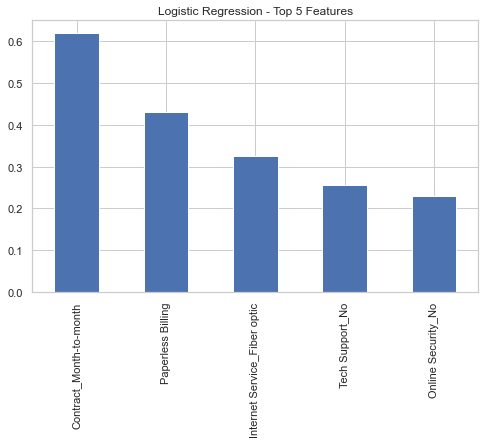

In [538]:
# Top 5 Features
top_features(X_test_eng, log_reg, "Logistic Regression")

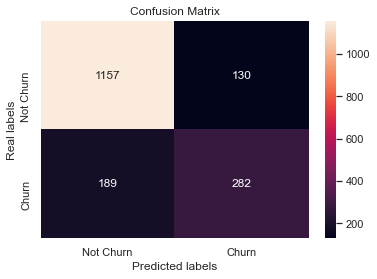

In [539]:
produce_confusion(y_test_pred, y_test)

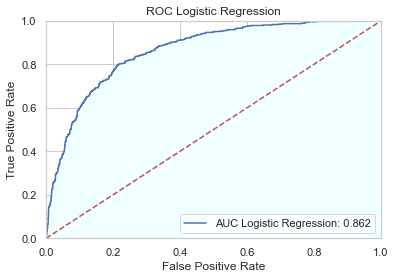

In [540]:
produce_roc_curve(log_reg, X_test_eng, y_test, 'Logistic Regression')

#### <a id = "10"> 5-5. Logistic Regression (Optimisation)</a>

In [603]:
## parameters tuning

lr_params = {
    'C': [0.001, 0.01, 0.1, 1.0],
    'class_weight': [None, 'balanced']
}

grid_cv = GridSearchCV(log_reg, param_grid = lr_params, cv = 5)
grid_cv.fit(X_train_eng, y_train)

print(f'best accuracy: {grid_cv.best_score_}')
print(f'best parameters: {grid_cv.best_params_}')

best accuracy: 0.8083047204510914
best parameters: {'C': 0.01, 'class_weight': None}


In [623]:
log_reg_opt = LogisticRegression(max_iter=1000, class_weight = 'balanced')
log_reg_opt.fit(X_train_eng, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [624]:
y_train_pred = log_reg_opt.predict(X_train_eng)
print("Train accuracy: ", accuracy_score(y_train, y_train_pred))

Train accuracy:  0.754835039817975


In [625]:
y_test_pred = log_reg_opt.predict(X_test_eng)

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.92      0.75      0.83      1287
           1       0.55      0.82      0.66       471

    accuracy                           0.77      1758
   macro avg       0.73      0.79      0.74      1758
weighted avg       0.82      0.77      0.78      1758



In [612]:
def calc_precision_recall(y_pred, y_true):
    
    y_pred = pd.Series(y_pred, index = y_true.index)
    
    TP = 0
    FP = 0
    FN = 0
    
    for i in y_true.index:
        if y_true[i] == y_pred[i] == 1:
            TP += 1
        elif y_true[i] != y_pred[i] and y_pred[i] == 1:
            FP += 1
        elif y_true[i] != y_pred[i] and y_pred[i] == 0:
            FN += 1
    
    try:
        precision = TP / (TP + FP)
    except:
        precision = 1
    
    try:
        recall = TP / (TP + FN)
    except:
        recall = 1
    
    return precision, recall

In [626]:
def produce_precision_recall(clf):
    y_test_prob = clf.predict_proba(X_test_eng)[:,1]
    precisions = []
    recalls = []

    cut_off = np.linspace(0, 1, 11)

    for threshold in cut_off:
        y_test_preds = []

        for prob in y_test_prob:
            if prob > threshold:
                y_test_preds.append(1)
            else:
                y_test_preds.append(0)

        precision, recall = calc_precision_recall(y_test_preds, y_test)

        precisions.append(precision)
        recalls.append(recall)   
    
    return precisions, recalls

In [613]:
calc_precision_recall(y_test_pred, y_test)

(0.5484330484330484, 0.8174097664543525)

In [627]:
lr_precisions, lr_recalls = produce_precision_recall(log_reg)
lr_opt_precision, lr_opt_recall = produce_precision_recall(log_reg_opt)

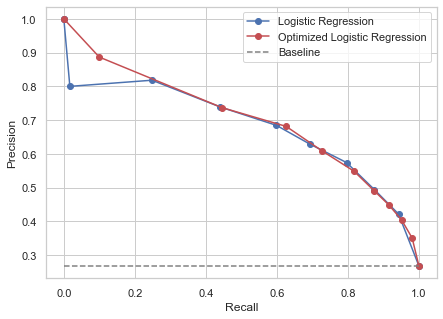

In [653]:
fig, ax = plt.subplots(figsize = (7,5))
ax.plot(lr_recalls, lr_precisions, label='Logistic Regression', marker='o', color='b')
ax.plot(lr_opt_recall, lr_opt_precision, label='Optimized Logistic Regression', marker='o', color='r')
baseline = len(y_test[y_test == 1]) / len(y_test)
ax.plot([0,1], [baseline, baseline], linestyle='--', label='Baseline', color='grey')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend()
plt.show()

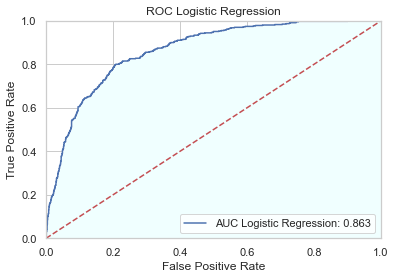

In [647]:
produce_roc_curve(log_reg_opt, X_test_eng, y_test, 'Logistic Regression')

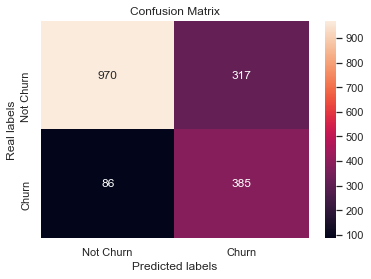

In [648]:
produce_confusion(y_test_pred, y_test)

### <a id = "11"> 6. Lists of Churn Likelihood</a>

#### <a id = "12"> 6-1. Churn risk of all our remaining customers</a>

In [686]:
churn_risk = churn[['CustomerID', 'Churn Label']].copy()
churn_risk.loc[:,'key'] = churn_risk.index

# Churn risk on the train set
risk_train = pd.DataFrame(log_reg_opt.predict_proba(X_train_eng)[:,1], index = X_train_eng.index)
risk_train.loc[:,'key'] = X_train_eng.index
### <a id = "11"> 6. Lists of Churn Likelihood</a>
# Churn risk on the test set 
risk_test = pd.DataFrame(log_reg_opt.predict_proba(X_test_eng)[:,1], index = X_test_eng.index)
risk_test.loc[:,'key'] = X_test_eng.index

# Sum up two results into one dataframe
risk_sum = risk_train.append(risk_test)

# Merge 'churn_risk' and 'risk_sum' tables
churn_risk_remaining = pd.merge(churn_risk, risk_sum, on='key')
churn_risk_remaining = churn_risk_remaining.drop('key', axis=1)
churn_risk_remaining = churn_risk_remaining[churn_risk_remaining['Churn Label'] == 'No']
churn_risk_remaining = churn_risk_remaining.rename(columns = {0: 'Churn Risk'})
churn_risk_remaining = churn_risk_remaining.sort_values(by = ['Churn Risk'], ascending = False)

churn_risk_remaining

,CustomerID,Churn Label,Churn Risk
4193,5150-ITWWB,No,0.942939
2565,6630-UJZMY,No,0.930593
4335,2545-EBUPK,No,0.925021
5709,7668-XCFYV,No,0.923852
5562,3320-VEOYC,No,0.922528
...,...,...,...
5355,1052-QJIBV,No,0.002392
3586,4277-BWBML,No,0.002346
5561,6928-ONTRW,No,0.002263
6721,4086-WITJG,No,0.002263


#### <a id = "13"> 6-2. Customers we think are at risk of churning</a>

In [689]:
high_risk = churn_risk_remaining.head(500)
high_risk

,CustomerID,Churn Label,Churn Risk
4193,5150-ITWWB,No,0.942939
2565,6630-UJZMY,No,0.930593
4335,2545-EBUPK,No,0.925021
5709,7668-XCFYV,No,0.923852
5562,3320-VEOYC,No,0.922528
...,...,...,...
6689,9626-WEQRM,No,0.743867
5900,8990-ZXLSU,No,0.743756
5742,2495-KZNFB,No,0.743753
2108,8705-WZCYL,No,0.743701
